In [58]:
#import dependencies

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## Merging stocks Data -for each vaccine into combined vaccine stock

In [59]:


# Dictionary containing tickers and corresponding file paths
csv_files = {
    'PFE': 'Resources/PFE_data.csv',  
    'AZN': 'Resources/AZN_data.csv',
    'BNTX': 'Resources/BNTX_data.csv',
    'MRNA': 'Resources/MRNA_data.csv',
    'JNJ': 'Resources/JNJ_data.csv',
    'GSK': 'Resources/GSK_data.csv',
    'NVAX':'Resources/NVAX_data.csv',
    'SNY': 'Resources/SNY_data.csv'
}

# Empty list to hold data from each file

combined_data = []

# Loop through each ticker and corresponding file
for ticker, file in csv_files.items():
    # Use Path() to handle both relative and absolute paths
    file_path = Path(file)

    # Check if the file exists before trying to load it
    if file_path.exists():
        # Load the current CSV file
        data = pd.read_csv(file_path)

        # Adjust the column names if necessary (e.g., 'Adj Close' instead of 'Adj_Close')
        # Ensure the 'Ticker' column exists or add it
        data['Ticker'] = ticker
        data = data[['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

        # Append this data to the combined list
        combined_data.append(data)
        print(f"Loaded data for {ticker} successfully.")
    else:
        print(f"Error: File for {ticker} at path '{file_path}' not found.")

# Concatenate all the data into a single DataFrame, if any files were successfully loaded
if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)

    # Save the combined data to a new CSV file
    combined_df.to_csv('Output/combined_vaccine_stocks.csv', index=False)

    # Preview the first few rows of the combined data
    print(combined_df.head())
else:
    print("No data to combine.")




Loaded data for PFE successfully.
Loaded data for AZN successfully.
Loaded data for BNTX successfully.
Loaded data for MRNA successfully.
Loaded data for JNJ successfully.
Loaded data for GSK successfully.
Loaded data for NVAX successfully.
Loaded data for SNY successfully.
  Ticker        Date       Open       High        Low      Close  Adj Close  \
0    PFE  2020-01-02  37.286530  37.333965  36.888046  37.134724  30.443775   
1    PFE  2020-01-03  36.736244  37.229603  36.688805  36.935486  30.280436   
2    PFE  2020-01-06  36.831120  37.001900  36.717270  36.888046  30.241545   
3    PFE  2020-01-07  37.115749  37.125237  36.698292  36.764706  30.140430   
4    PFE  2020-01-08  36.774193  37.210625  36.764706  37.058823  30.381554   

     Volume  
0  16514072  
1  14922848  
2  15771951  
3  20108107  
4  16403507  


## Cleaning the Data-

In [60]:
# Check for missing values-

missing_values = combined_df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [61]:
# Check for Duplicates-

duplicates = combined_df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Remove duplicate rows if any
stock_data_cleaned = combined_df.drop_duplicates()

Number of duplicate rows: 0


In [62]:

# Ensure 'Date' column is in datetime format

stock_data_cleaned['Date'] = pd.to_datetime(stock_data_cleaned['Date'])

# Verify the data types
print(stock_data_cleaned.dtypes)

Ticker               object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [63]:
# Identify outliers using IQR

# Convert relevant columns to numeric, if not already
columns_to_convert = ['Open', 'Close', 'Volume']  # Add all relevant columns
for col in columns_to_convert:
    stock_data_cleaned[col] = pd.to_numeric(stock_data_cleaned[col], errors='coerce')

# Drop rows with NaN values in the columns of interest
stock_data_cleaned = stock_data_cleaned.dropna(subset=columns_to_convert)

# Calculate the quartiles and IQR for the numeric columns
Q1 = stock_data_cleaned[columns_to_convert].quantile(0.25)
Q3 = stock_data_cleaned[columns_to_convert].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers using the IQR method
outliers = stock_data_cleaned[((stock_data_cleaned[columns_to_convert] < (Q1 - 1.5 * IQR)) | (stock_data_cleaned[columns_to_convert] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Outliers:\n", outliers)

# Optionally, remove outliers
stock_data_cleaned_no_outliers = stock_data_cleaned[~((stock_data_cleaned[columns_to_convert] < (Q1 - 1.5 * IQR)) | (stock_data_cleaned[columns_to_convert] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Optional: print or work with the cleaned data
print("Data without outliers:\n", stock_data_cleaned_no_outliers)



Outliers:
      Ticker       Date       Open       High        Low      Close  Adj Close  \
3       PFE 2020-01-07  37.115749  37.125237  36.698292  36.764706  30.140430   
5       PFE 2020-01-09  37.258064  37.258064  36.802658  36.897533  30.249331   
6       PFE 2020-01-10  36.982922  37.599621  36.973434  37.466793  30.716017   
8       PFE 2020-01-14  37.409866  38.026566  37.286530  38.017078  31.167152   
9       PFE 2020-01-15  38.130932  38.776093  38.111954  38.586338  31.633842   
...     ...        ...        ...        ...        ...        ...        ...   
7967    SNY 2023-09-06   9.070000  10.300000   9.040000   9.740000   9.740000   
7968    SNY 2023-09-07   9.820000   9.980000   8.700000   9.150000   9.150000   
7970    SNY 2023-09-11   9.020000   9.020000   7.730000   7.820000   7.820000   
7986    SNY 2023-10-03   7.080000   8.150000   6.730000   7.670000   7.670000   
8038    SNY 2023-12-15   5.730000   5.830000   5.380000   5.400000   5.400000   

        Volume  

In [64]:
# Summary of cleaned data
print(stock_data_cleaned.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8048 entries, 0 to 8047
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     8048 non-null   object        
 1   Date       8048 non-null   datetime64[ns]
 2   Open       8048 non-null   float64       
 3   High       8048 non-null   float64       
 4   Low        8048 non-null   float64       
 5   Close      8048 non-null   float64       
 6   Adj Close  8048 non-null   float64       
 7   Volume     8048 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 503.1+ KB
None


In [65]:
# Filter all rows (:) and specific columns: 'Ticker', 'Date', 'Open', 'Close'
filtered_df = combined_df.loc[:, ['Ticker', 'Date', 'Open', 'Close','Volume']]


# Convert the 'Date' column to datetime format

filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

filtered_df

,Ticker,Date,Open,Close,Volume
0,PFE,2020-01-02,37.286530,37.134724,16514072
1,PFE,2020-01-03,36.736244,36.935486,14922848
2,PFE,2020-01-06,36.831120,36.888046,15771951
3,PFE,2020-01-07,37.115749,36.764706,20108107
4,PFE,2020-01-08,36.774193,37.058823,16403507
...,...,...,...,...,...
8043,SNY,2023-12-22,4.940000,5.060000,7910000
8044,SNY,2023-12-26,5.150000,5.050000,4775900
8045,SNY,2023-12-27,5.020000,4.940000,8607300
8046,SNY,2023-12-28,4.950000,4.910000,7460100


### Calulate Yearly change in stocks

In [66]:
# Group by yearly

# Group by Ticker and Year, and aggregate first 'Open', last 'Close', and total 'Volume'
yearly_grouped = filtered_df.groupby([filtered_df['Ticker'], filtered_df['Date'].dt.year]).agg(
    first_open=('Open', 'first'),   # First open price in the year
    last_close=('Close', 'last'),   # Last close price in the year
    total_volume=('Volume', 'sum')  # Sum of volume for each year
).reset_index()


In [67]:


# Step 4: Calculate the yearly change (absolute difference or percentage)
yearly_grouped['change'] = yearly_grouped['last_close'] - yearly_grouped['first_open']

In [68]:
# Calculate the percentage change
yearly_grouped['percentage_change'] = (yearly_grouped['last_close'] - yearly_grouped['first_open']) / yearly_grouped['first_open'] * 100

#  Print the result, including 'Ticker' and 'Year'
print(yearly_grouped[['Ticker', 'Date', 'first_open', 'last_close', 'change', 'percentage_change']])

   Ticker  Date  first_open  last_close      change  percentage_change
0     AZN  2020   50.299999   49.990002   -0.309998          -0.616297
1     AZN  2021   50.919998   58.250000    7.330002          14.395134
2     AZN  2022   58.270000   67.800003    9.530003          16.354904
3     AZN  2023   68.650002   67.349998   -1.300003          -1.893668
4    BNTX  2020   35.750000   81.519997   45.769997         128.027963
5    BNTX  2021   85.450996  257.799988  172.348991         201.693367
6    BNTX  2022  253.869995  150.220001 -103.649994         -40.827981
7    BNTX  2023  152.940002  105.540001  -47.400002         -30.992547
8     GSK  2020   46.810001   36.799999  -10.010002         -21.384324
9     GSK  2021   37.720001   44.099998    6.379997          16.914096
10    GSK  2022   44.110001   35.139999   -8.970001         -20.335527
11    GSK  2023   34.939999   37.060001    2.120003           6.067552
12    JNJ  2020  145.869995  157.380005   11.510010           7.890594
13    

In [69]:
# Set the ticker as index for referencing
#yearly_change_df = yearly_grouped.set_index("Ticker")
yearly_grouped

,Ticker,Date,first_open,last_close,total_volume,change,percentage_change
0,AZN,2020,50.299999,49.990002,1519552100,-0.309998,-0.616297
1,AZN,2021,50.919998,58.250000,2140467100,7.330002,14.395134
2,AZN,2022,58.270000,67.800003,1649977200,9.530003,16.354904
3,AZN,2023,68.650002,67.349998,1260493800,-1.300003,-1.893668
4,BNTX,2020,35.750000,81.519997,609044300,45.769997,128.027963
5,BNTX,2021,85.450996,257.799988,795461900,172.348991,201.693367
6,BNTX,2022,253.869995,150.220001,334527400,-103.649994,-40.827981
7,BNTX,2023,152.940002,105.540001,173063800,-47.400002,-30.992547
8,GSK,2020,46.810001,36.799999,1024869000,-10.010002,-21.384324
9,GSK,2021,37.720001,44.099998,1169661000,6.379997,16.914096


In [77]:
# Define the function to calculate base 100
def calculate_base_100(group):
    # Add 1 to percentage_change to calculate cumulative change (1 + percentage_change/100)
    group['adjusted_change'] = (group['percentage_change'] / 100) + 1
    
    # Calculate base 100 as cumulative product, starting with 100
    group['base_100'] = group['adjusted_change'].cumprod() * 100

     # Set the first base_100 value explicitly to 100 for proper normalization
    group['base_100'].iat[0] = 100
    
    return group

# Apply the function to each ticker group
yearly_change_df = yearly_grouped.groupby('Ticker').apply(calculate_base_100)

# Drop the temporary 'adjusted_change' column (optional)
yearly_change_df.drop(columns=['adjusted_change'], inplace=True)

# Now 'yearly_change_df' contains the 'base_100' column
print(yearly_change_df)

          Ticker  Date  first_open  last_close  total_volume      change  \
Ticker                                                                     
AZN    0     AZN  2020   50.299999   49.990002    1519552100   -0.309998   
       1     AZN  2021   50.919998   58.250000    2140467100    7.330002   
       2     AZN  2022   58.270000   67.800003    1649977200    9.530003   
       3     AZN  2023   68.650002   67.349998    1260493800   -1.300003   
BNTX   4    BNTX  2020   35.750000   81.519997     609044300   45.769997   
       5    BNTX  2021   85.450996  257.799988     795461900  172.348991   
       6    BNTX  2022  253.869995  150.220001     334527400 -103.649994   
       7    BNTX  2023  152.940002  105.540001     173063800  -47.400002   
GSK    8     GSK  2020   46.810001   36.799999    1024869000  -10.010002   
       9     GSK  2021   37.720001   44.099998    1169661000    6.379997   
       10    GSK  2022   44.110001   35.139999    1474139900   -8.970001   
       11   

C:\Users\Muskan\AppData\Local\Temp\ipykernel_20812\1600561746.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_change_df = yearly_grouped.groupby('Ticker').apply(calculate_base_100)


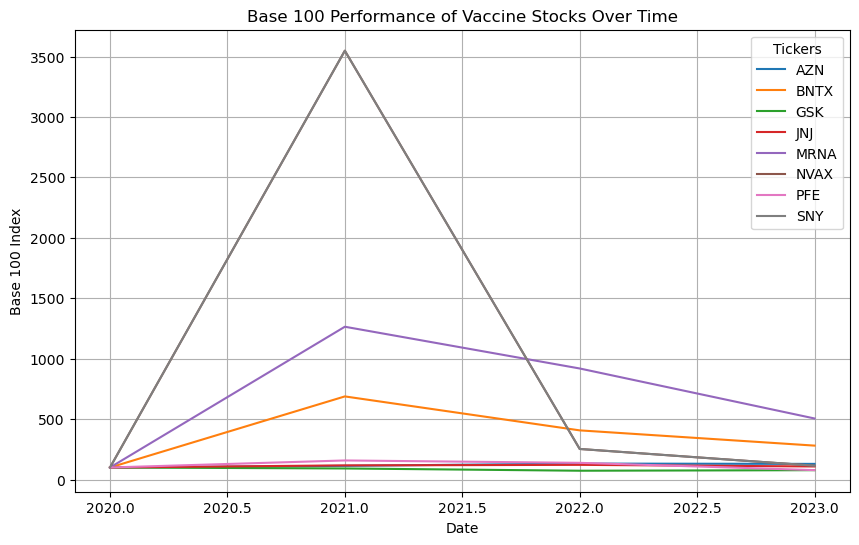

In [78]:
# Plotting the Base 100 for each ticker
plt.figure(figsize=(10, 6))

# Loop through each ticker and plot its base_100 over time
tickers = yearly_change_df['Ticker'].unique()
for ticker in tickers:
    # Select the data for the current ticker
    ticker_data = yearly_change_df[yearly_change_df['Ticker'] == ticker]
    
    # Plot base_100 against the date
    plt.plot(ticker_data['Date'], ticker_data['base_100'], label=ticker)

# Customize the plot
plt.title('Base 100 Performance of Vaccine Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Base 100 Index')
plt.legend(title="Tickers")
plt.grid(True)

# Show the plot
plt.show()

In [72]:
# Total stock Volume for each stock

combined_df

volume_df=combined_df.groupby('Ticker')['Volume'].sum().reset_index()

volume_df

,Ticker,Volume
0,AZN,6570490200
1,BNTX,1912097400
2,GSK,4504139000
3,JNJ,8456534600
4,MRNA,10536994000
5,NVAX,6379747800
6,PFE,30027788466
7,SNY,6379747800


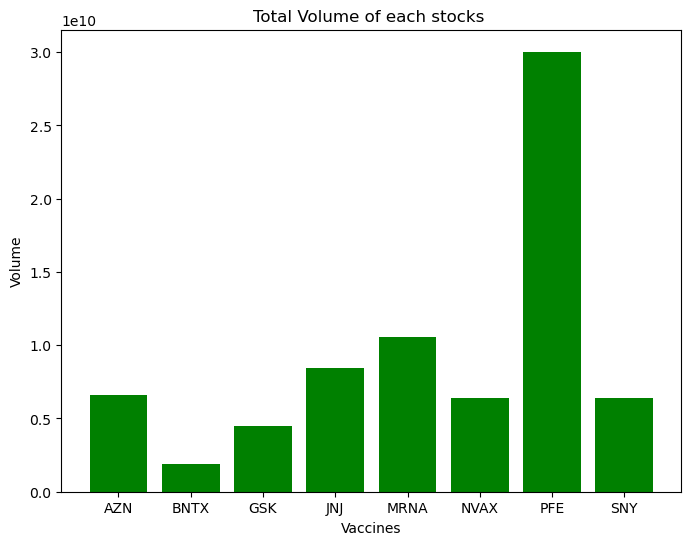

<Figure size 640x480 with 0 Axes>

In [73]:
# bar plot for volume of stock per vaccine 

plt.figure(figsize=(8, 6))
plt.bar(volume_df['Ticker'], volume_df['Volume'], color='green')
plt.title('Total Volume of each stocks ')
plt.xlabel('Vaccines')
plt.ylabel('Volume')
plt.show()
plt.savefig('Output/Total Volume of Stocks per vaccine ')


In [74]:
# Create Bar charts -for each vaccine comparing stocks volume per year 

yearly_volume_reset = yearly_change_df.reset_index()




# Step 1: Pivot the DataFrame to have 'Date' as columns and 'Ticker' as rows
pivoted_volume = yearly_volume_reset.pivot( columns='Date', values='total_volume')

# Step 2: Plot multi-bar chart
pivoted_volume.plot(kind='bar', figsize=(10, 6))

# Step 3: Customize the plot
plt.title('Total Volume Yearly for Each Ticker')
plt.ylabel('Total Volume')
plt.xlabel('Tickers')
plt.xticks(rotation=0)  # Keep ticker labels horizontal
plt.legend(title='Year')
plt.tight_layout()

# Show the plot
plt.show()

plt.savefig('Output/Total Volume Yearly for each vaccine ')

ValueError: cannot insert Ticker, already exists

### Calculate Quarterly change of stocks 

In [21]:
# Step 2: Group by quarters

quarterly_change_df = filtered_df.groupby([filtered_df['Ticker'],filtered_df['Date'].dt.to_period('Q')])


quarterly_change_df = filtered_df.groupby([filtered_df['Ticker'], filtered_df['Date'].dt.to_period('Q')]).agg(
    first_open=('Open', 'first'),   # First open price in the quarter
    last_close=('Close', 'last'),   # Last close price in the quarter
    total_volume=('Volume', 'sum')  # Sum of volume for quarter
).reset_index()




In [22]:
# Step 4: Calculate the quarterly change (absolute difference or percentage)
quarterly_change_df['change'] = quarterly_change_df['last_close'] - quarterly_change_df['first_open']

# Calculate the percentage change

quarterly_change_df['percentage_change'] = (quarterly_change_df['last_close'] - quarterly_change_df['first_open']) / quarterly_change_df['first_open'] * 100

quarterly_change_df

,Ticker,Date,first_open,last_close,total_volume,change,percentage_change
0,AZN,2020Q1,50.299999,44.660000,262929800,-5.639999,-11.212723
1,AZN,2020Q2,43.750000,52.889999,314915100,9.139999,20.891427
2,AZN,2020Q3,52.830002,54.799999,408882100,1.969997,3.728937
3,AZN,2020Q4,55.200001,49.990002,532825100,-5.209999,-9.438404
4,AZN,2021Q1,50.919998,49.720001,687102700,-1.199997,-2.356632
...,...,...,...,...,...,...,...
123,SNY,2022Q4,18.350000,10.280000,396661600,-8.070001,-43.978204
124,SNY,2023Q1,10.590000,6.930000,404350300,-3.660000,-34.560909
125,SNY,2023Q2,6.980000,7.430000,371827700,0.450000,6.446989
126,SNY,2023Q3,7.480000,7.240000,575572600,-0.240000,-3.208559


In [23]:
# Plot  the quarterly change on each vaccine for year 2021


# Filter for data where the year is 2021
# Step 1: Create the filter for 2021 quarters

filter_2021 = (
    (quarterly_change_df['Date'] == '2021Q1') |
    (quarterly_change_df['Date'] == '2021Q2') |
    (quarterly_change_df['Date'] == '2021Q3') |
    (quarterly_change_df['Date'] == '2021Q4')
)

quarterly_change_df1=quarterly_change_df[['Ticker','Date','percentage_change']]


# Step 2: Apply the filter
data_q1_to_q4_2021 = quarterly_change_df1[filter_2021]

# Display the filtered DataFrame
print(data_q1_to_q4_2021[['Ticker', 'Date', 'percentage_change']])





    Ticker    Date  percentage_change
4      AZN  2021Q1          -2.356632
5      AZN  2021Q2          20.741788
6      AZN  2021Q3           0.317358
7      AZN  2021Q4          -1.754092
20    BNTX  2021Q1          27.780842
21    BNTX  2021Q2         102.588002
22    BNTX  2021Q3          21.599105
23    BNTX  2021Q4           2.709158
36     GSK  2021Q1          -5.381767
37     GSK  2021Q2          11.384615
38     GSK  2021Q3          -4.379379
39     GSK  2021Q4          15.324259
52     JNJ  2021Q1           4.521750
53     JNJ  2021Q2           1.316113
54     JNJ  2021Q3          -1.966739
55     JNJ  2021Q4           5.906029
68    MRNA  2021Q1          22.120669
69    MRNA  2021Q2          77.745841
70    MRNA  2021Q3          62.869226
71    MRNA  2021Q4         -29.121200
84    NVAX  2021Q1          60.878441
85    NVAX  2021Q2          15.700271
86    NVAX  2021Q3          -3.576745
87    NVAX  2021Q4         -25.058926
100    PFE  2021Q1          -1.735827
101    PFE  

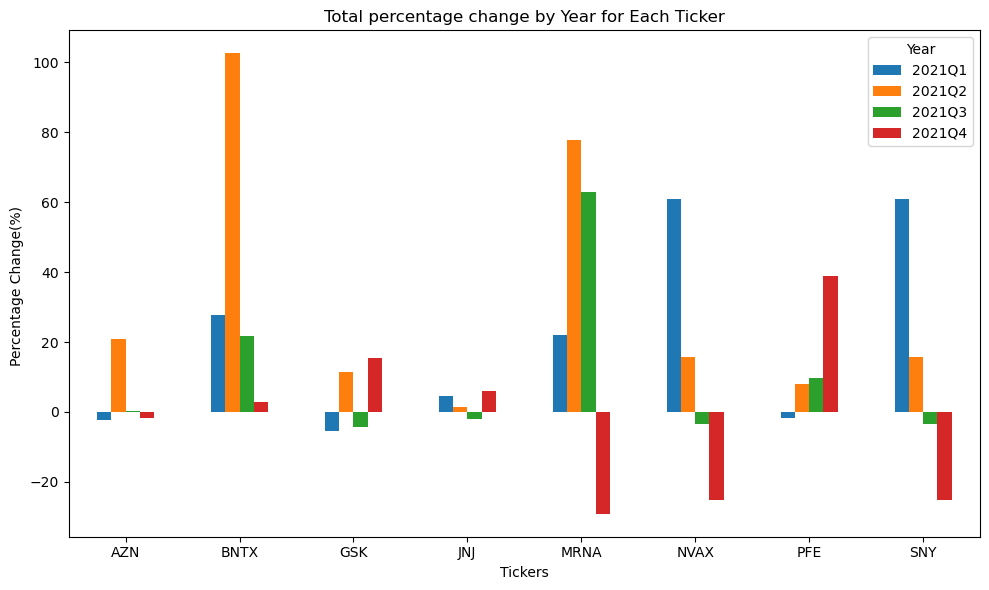

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot the Data-
# Step 1: Pivot the DataFrame to have 'Date' as columns and 'Ticker' as rows
pivoted_data = data_q1_to_q4_2021.pivot(index='Ticker', columns='Date', values='percentage_change')


# Step 2: Plot multi-bar chart
pivoted_data.plot(kind='bar', figsize=(10, 6))

# Step 3: Customize the plot
plt.title('Total percentage change by Year for Each Ticker')
plt.ylabel('Percentage Change(%) ')
plt.xlabel('Tickers')
plt.xticks(rotation=0)  # Keep ticker labels horizontal
plt.legend(title='Year')
plt.tight_layout()

# Show the plot
plt.show()

plt.savefig('Output/Total percentage change for year 2021 Quarterly  ')


In [25]:
# Analyze the Volume of 2021 year quarterly for each stocks-



# Filter for data where the year is 2021
# Step 1: Create the filter for 2021 quarters

filter_2021 = (
    (quarterly_change_df['Date'] == '2021Q1') |
    (quarterly_change_df['Date'] == '2021Q2') |
    (quarterly_change_df['Date'] == '2021Q3') |
    (quarterly_change_df['Date'] == '2021Q4')
)

quarterly_change_df=quarterly_change_df[['Ticker','Date','total_volume']]


# Step 2: Apply the filter
data_q1_to_q4_2021 = quarterly_change_df[filter_2021]

# Display the filtered DataFrame
print(data_q1_to_q4_2021[['Ticker', 'Date', 'total_volume']])





    Ticker    Date  total_volume
4      AZN  2021Q1     687102700
5      AZN  2021Q2     500929200
6      AZN  2021Q3     660915000
7      AZN  2021Q4     291520200
20    BNTX  2021Q1     117849100
21    BNTX  2021Q2     193137200
22    BNTX  2021Q3     274493200
23    BNTX  2021Q4     209982400
36     GSK  2021Q1     362915900
37     GSK  2021Q2     309664400
38     GSK  2021Q3     227896000
39     GSK  2021Q4     269184700
52     JNJ  2021Q1     507242900
53     JNJ  2021Q2     442220400
54     JNJ  2021Q3     380542000
55     JNJ  2021Q4     468562600
68    MRNA  2021Q1     746976900
69    MRNA  2021Q2     607077400
70    MRNA  2021Q3    1183445100
71    MRNA  2021Q4     809748100
84    NVAX  2021Q1     271581600
85    NVAX  2021Q2     250774300
86    NVAX  2021Q3     309091600
87    NVAX  2021Q4     382006500
100    PFE  2021Q1    2029927100
101    PFE  2021Q2    1659619400
102    PFE  2021Q3    2078643300
103    PFE  2021Q4    2545830600
116    SNY  2021Q1     271581600
117    SNY

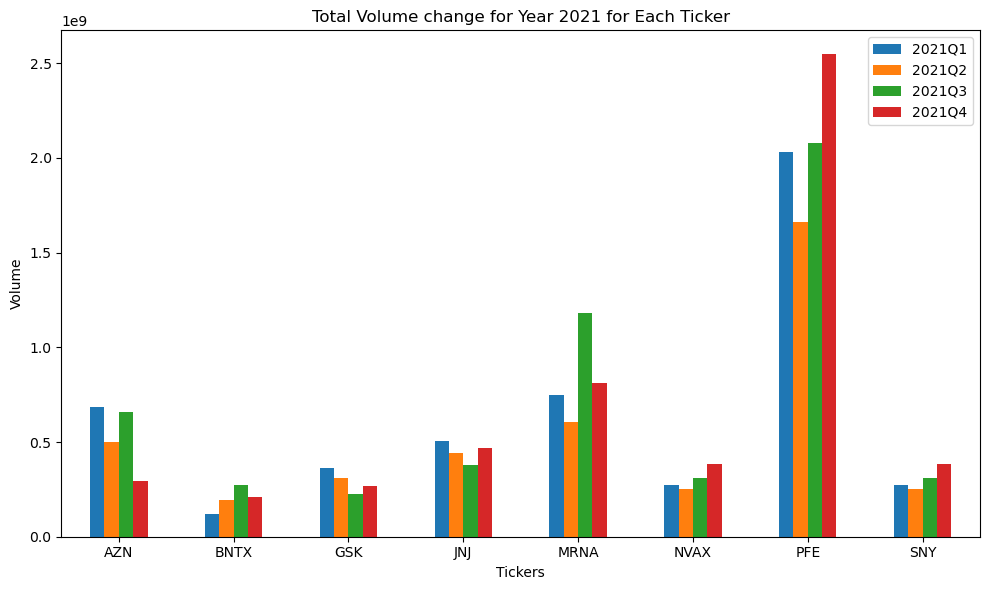

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot the Data-
# Step 1: Pivot the DataFrame to have 'Date' as columns and 'Ticker' as rows
pivoted_data = data_q1_to_q4_2021.pivot(index='Ticker', columns='Date', values='total_volume')


# Step 2: Plot multi-bar chart
pivoted_data.plot(kind='bar', figsize=(10, 6))

# Step 3: Customize the plot
plt.title('Total Volume change for Year 2021 for Each Ticker')
plt.ylabel('Volume')
plt.xlabel('Tickers')
plt.xticks(rotation=0)  # Keep ticker labels horizontal
plt.legend(title='')
plt.tight_layout()

# Show the plot
plt.show()

plt.savefig('Output/Total Volume Change for year 2021 for each vaccine')